In [127]:
from sklearn import neighbors, datasets
from sklearn.base import is_classifier
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from google.colab import drive
import pandas as pd

import numpy as np

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing

In [101]:
# carico dataset
df = pd.read_csv("https://raw.githubusercontent.com/btlgs2000/machine_learning_basic/master/data/houses_train.csv")

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2315,2014-06-11 00:00:00,700000.0,3.0,2.75,2500,7378,1.0,0,0,5,1390,1110,1948,1985,10050 11th Ave NW,Seattle,WA 98177,USA
1,1434,2014-05-28 00:00:00,225000.0,3.0,2.00,2030,24829,1.0,0,0,4,1220,810,1979,0,36721 34th Ave S,Auburn,WA 98001,USA
2,1412,2014-05-27 00:00:00,754950.0,3.0,2.50,2610,7256,2.0,0,0,3,2610,0,2014,0,12108 NE 106th Pl,Kirkland,WA 98033,USA
3,3837,2014-07-02 00:00:00,411000.0,4.0,2.00,2370,76665,2.0,0,0,4,2370,0,1978,2000,35516 44th Ave S,Auburn,WA 98001,USA
4,4267,2014-07-09 00:00:00,215000.0,3.0,1.00,1200,7280,1.0,0,0,4,1200,0,1967,0,4503 S 256th St,Kent,WA 98032,USA


In [102]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,3680.000000,3.680000e+03,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000
mean,2304.020652,5.574161e+05,3.392935,2.158764,2136.351359,14630.927174,1.508016,0.007065,0.241576,3.450000,1821.329891,315.021467,1970.725272,813.998370
std,1323.955439,6.086800e+05,0.909587,0.788535,975.463212,32124.162388,0.539803,0.083769,0.781729,0.677924,872.850900,467.324807,29.663205,980.434151
min,0.000000,0.000000e+00,0.000000,0.000000,370.000000,638.000000,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,1168.750000,3.250000e+05,3.000000,1.750000,1460.000000,5000.000000,1.000000,0.000000,0.000000,3.000000,1180.000000,0.000000,1951.000000,0.000000
50%,2290.500000,4.600000e+05,3.000000,2.250000,1970.000000,7651.000000,1.500000,0.000000,0.000000,3.000000,1580.000000,0.000000,1976.000000,0.000000
75%,3445.250000,6.590000e+05,4.000000,2.500000,2610.000000,11085.750000,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1996.250000,1999.000000
max,4599.000000,2.659000e+07,9.000000,8.000000,13540.000000,641203.000000,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [103]:
# tolgo campioni con prezzo a zero
dd = df.price==0
print(dd.size)
df_with_price_zeros=df[dd]
df_with_price_zeros.head()
print("Price size zero: " + str(df_with_price_zeros.price.size))
df_without_price_zeros=df[df.price!=0]
print("Price size senza zero:" + str(df_without_price_zeros.price.size))

print("Price size totali:" + str(df_with_price_zeros.price.size+df_without_price_zeros.price.size))

# dataset senza campioni con prezzo zero
df = df_without_price_zeros
print("Price size zero:" + str(df[df.price==0].price.size ) )

3680
Price size zero: 41
Price size senza zero:3639
Price size totali:3680
Price size zero:0


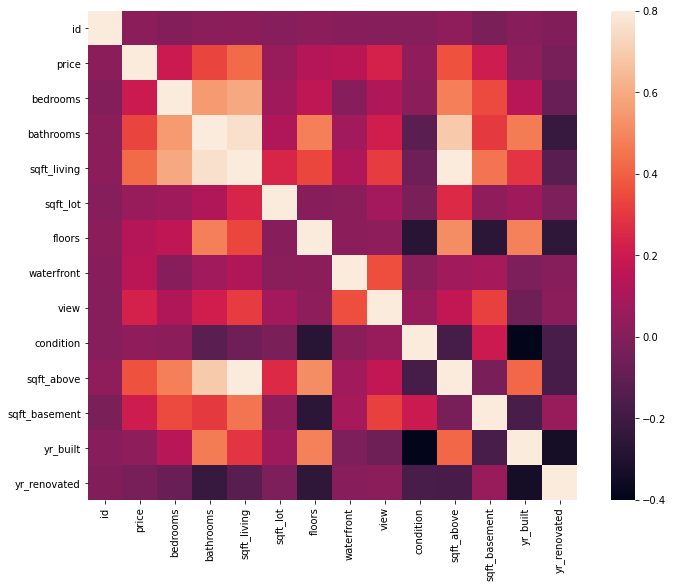

In [104]:
import seaborn as sns 
import matplotlib.pyplot  as plt
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

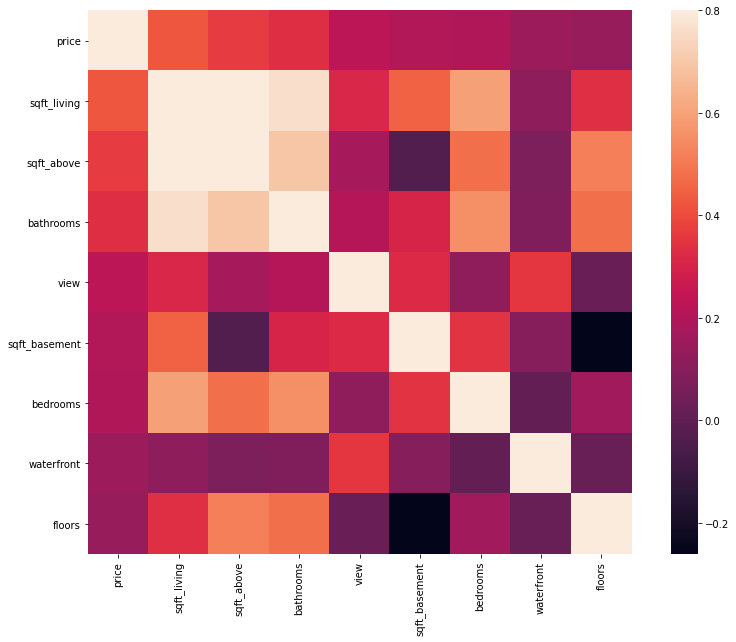

In [105]:
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(df[cols].corr(), vmax=.8, square=True);

In [106]:
# tolgo colonne non significative
#X = df.drop(['price','id','date','street','city','statezip','country','yr_built','yr_renovated','view','waterfront'], axis=1)
X = df.drop(['price','id','date','street','city','statezip','country'], axis=1)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,3.0,2.75,2500,7378,1.0,0,0,5,1390,1110,1948,1985
1,3.0,2.00,2030,24829,1.0,0,0,4,1220,810,1979,0
2,3.0,2.50,2610,7256,2.0,0,0,3,2610,0,2014,0
3,4.0,2.00,2370,76665,2.0,0,0,4,2370,0,1978,2000
4,3.0,1.00,1200,7280,1.0,0,0,4,1200,0,1967,0


In [107]:
y = df.price
#print("campioni con price zero: " + str(np.count_nonzero(train_y==0)))
y.head()


0    700000.0
1    225000.0
2    754950.0
3    411000.0
4    215000.0
Name: price, dtype: float64

# Standard Method

In [108]:
# scalo i campioni
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled[:10]

array([[-0.42589794,  0.76589264,  0.38411008, -0.22458095, -0.93996037,
        -0.08148008, -0.30641158,  2.3009053 , -0.49238621,  1.71209556,
        -0.76614153,  1.19397309],
       [-0.42589794, -0.19483929, -0.10174696,  0.31833359, -0.93996037,
        -0.08148008, -0.30641158,  0.81922164, -0.68918684,  1.06756703,
         0.27833936, -0.83070295],
       [-0.42589794,  0.44564866,  0.4978213 , -0.22837647,  0.91197021,
        -0.08148008, -0.30641158, -0.66246203,  0.91994778, -0.67266002,
         1.45759197, -0.83070295],
       [ 0.67955328, -0.19483929,  0.24972409,  1.93099293,  0.91197021,
        -0.08148008, -0.30641158,  0.81922164,  0.64211159, -0.67266002,
         0.24464642,  1.20927291],
       [-0.42589794, -1.47581519, -0.95974981, -0.22762981, -0.93996037,
        -0.08148008, -0.30641158,  0.81922164, -0.71233986, -0.67266002,
        -0.12597583, -0.83070295],
       [ 1.78500449, -0.51508326,  0.02230165, -0.23102089, -0.93996037,
        -0.08148008, -

In [109]:
# genero features polinomiali
pft = PolynomialFeatures(degree = 2)
X_poly = pft.fit_transform(X_scaled)

In [111]:
train_X, test_X, train_y, test_y = train_test_split(X_poly, y, test_size=0.2, random_state=0, shuffle=True)

In [112]:
print(train_y[:5])

print(test_y[:5])



1670    1038000.0
2401     770000.0
1023     453246.0
2351     435000.0
2308     352500.0
Name: price, dtype: float64
447     399500.0
1465    782000.0
1998    280000.0
1171    337500.0
3255    161700.0
Name: price, dtype: float64


In [113]:
#reg = LinearRegression()
reg = Ridge(alpha = 3)
reg.fit(train_X, train_y)

Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [114]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [115]:
y_true = test_y
y_pred = reg.predict(test_X)
#print(mean_absolute_error(y_true, y_pred))
#print(mean_squared_error(y_true, y_pred))
print(mean_absolute_percentage_error(y_true, y_pred))


35.79350817853249


In [116]:
print(type(test_X))
print(test_X.shape)

<class 'numpy.ndarray'>
(728, 91)


In [117]:
type(test_X)

numpy.ndarray

In [118]:
type(X)

pandas.core.frame.DataFrame

In [119]:
# carico dataset di test
dataset_test = pd.read_csv("https://raw.githubusercontent.com/btlgs2000/machine_learning_basic/master/data/houses_test_no_price.csv")
dataset_test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,858,2014-05-19 00:00:00,2.0,2.00,1420,9191,1.5,0,2,5,1420,0,1928,1970,800 NE 95th St,Seattle,WA 98115,USA
1,1874,2014-06-04 00:00:00,4.0,2.50,4060,9734,1.0,0,4,3,2150,1910,1977,2004,19304 65th Ave NE,Kenmore,WA 98028,USA
2,918,2014-05-19 00:00:00,3.0,1.75,1800,10200,1.0,0,0,3,1800,0,1967,2011,17110-17116 146th Ave SE,Renton,WA 98058,USA
3,475,2014-05-12 00:00:00,2.0,2.50,1230,1391,2.0,0,0,3,870,360,2004,2003,106 24th Ave E,Seattle,WA 98112,USA
4,2466,2014-06-13 00:00:00,4.0,2.50,2540,6365,2.0,0,0,3,1870,670,2000,0,2107 Davis Ave S,Renton,WA 98055,USA


In [120]:
X_test = dataset_test.drop(['id','date','street','city','statezip','country'], axis=1)
X_test.head()



,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,2.0,2.00,1420,9191,1.5,0,2,5,1420,0,1928,1970
1,4.0,2.50,4060,9734,1.0,0,4,3,2150,1910,1977,2004
2,3.0,1.75,1800,10200,1.0,0,0,3,1800,0,1967,2011
3,2.0,2.50,1230,1391,2.0,0,0,3,870,360,2004,2003
4,4.0,2.50,2540,6365,2.0,0,0,3,1870,670,2000,0


In [121]:
X_test.shape

(920, 12)

In [122]:
X.shape

(3639, 12)

In [123]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,3.0,2.75,2500,7378,1.0,0,0,5,1390,1110,1948,1985
1,3.0,2.00,2030,24829,1.0,0,0,4,1220,810,1979,0
2,3.0,2.50,2610,7256,2.0,0,0,3,2610,0,2014,0
3,4.0,2.00,2370,76665,2.0,0,0,4,2370,0,1978,2000
4,3.0,1.00,1200,7280,1.0,0,0,4,1200,0,1967,0


In [124]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled[:10]

array([[-1.53134916, -0.19483929, -0.73232737, -0.16817708, -0.01399508,
        -0.08148008,  2.29880276,  2.3009053 , -0.45765668, -0.67266002,
        -1.44000016,  1.17867328],
       [ 0.67955328,  0.44564866,  1.99674195, -0.15128391, -0.93996037,
        -0.08148008,  4.9040171 , -0.66246203,  0.38742841,  3.43083832,
         0.21095349,  1.21335287],
       [-0.42589794, -0.51508326, -0.33950678, -0.13678628, -0.93996037,
        -0.08148008, -0.30641158, -0.66246203, -0.01774937, -0.67266002,
        -0.12597583,  1.22049278],
       [-1.53134916,  0.44564866, -0.92873766, -0.4108413 ,  0.91197021,
        -0.08148008, -0.30641158, -0.66246203, -1.09436463,  0.10077422,
         1.12066265,  1.21233288],
       [ 0.67955328,  0.44564866,  0.42545962, -0.25609619,  0.91197021,
        -0.08148008, -0.30641158, -0.66246203,  0.06328618,  0.76678704,
         0.98589092, -0.83070295],
       [ 0.67955328,  0.44564866,  0.45647177, -0.30276239,  0.91197021,
        -0.08148008, -

In [125]:
X_test_poly = pft.fit_transform(X_test_scaled)

In [128]:
type(X_test_poly)
print(X_test_poly.shape)
y_test_pred = reg.predict(X_test_poly)

df = pd.DataFrame(y_test_pred, columns=['prezzo'])
df.to_csv('drive/My Drive/Colab Notebooks/Backpropagators.csv')

(920, 91)


In [129]:
y_test_pred[:10]

array([ 729880.73322142, 1098347.00476925,  457013.0873061 ,
        388815.64311513,  545389.54101007,  538958.97917243,
        414130.11497152,  445078.99483583,  355387.24639836,
        380288.53968702])

# Test Pipeline


In [131]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
pipeline = Pipeline([('scaler', StandardScaler()), ('Regressor', Ridge())])



In [132]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Regressor',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [133]:
# score che eredita dall'ultimo oggetto
pipeline.score(test_X, test_y)

0.2780020216793049

# Pipeline + Grid Search

In [134]:
alpha_to_test = 2.0**np.arange(-140, +140)
params = {'Regressor__alpha': alpha_to_test}

In [135]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, verbose=1, scoring= make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [136]:
grid.fit(train_X, train_y)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.03359e-16): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.56486e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10705e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.02193e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.03359e-16): result may not be accurate.
  overwrite_a=True).T

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Regressor',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'Regressor__alpha': ar...
       2.12676479e+37, 4.25352959e+37, 8.50705917e+37, 1.70141183e+38,
       3.40282367e+38, 6.80564734e+38, 

In [137]:
grid.best_params_

{'Regressor__alpha': 128.0}

In [140]:
# score che eredita dall'ultimo oggetto
estimated_y = grid.predict(test_X)

In [141]:
mean_absolute_percentage_error(test_y, estimated_y)

35.16470279317571

In [142]:
df = pd.DataFrame(estimated_y, columns=['prezzo'])
df.to_csv('drive/My Drive/Colab Notebooks/Backpropagators_pipeline.csv')